In [ ]:
!pip install gtsam

In [1]:
from __future__ import print_function

import math
import unittest
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import linalg, matrix

from sympy import Matrix
from mpl_toolkits.mplot3d import Axes3D  # pylint: disable=W0611

import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import mpl_toolkits.mplot3d.axes3d as p3

# Required to do animations in colab
from matplotlib import animation
from IPython.display import HTML
from mobileManipulator import FourLinkMM
import gtsam
import gtsam.utils.plot as gtsam_plot
from gtsam import Pose2
import shapely
from shapely.geometry import Polygon
from shapely import affinity
from utils import *

# Setup Environment with obstacles

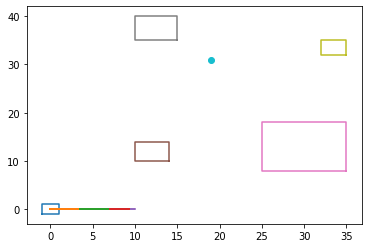

In [2]:
from rrt_manipulator import *
max_x = 50
max_y = 50
obstacles = [shapely.geometry.box(10, 10, 14, 14), shapely.geometry.box(25, 8, 35, 18), shapely.geometry.box(10, 35, 15, 40), shapely.geometry.box(32, 32, 35,35)]
env = Environment(max_x, max_y, obstacles=obstacles, num_obstacles=5, obstacle_size=6)
QStart = Pose2(10, 0, 0)
start_config = (Pose2(0, 0, 0), vector4(0, 0, 0, 0), QStart)
QGoal = Pose2(19, 31, np.pi/2)
arm = FourLinkMM()
base, link_1, link_2, link_3, link_4 = arm.create_manipulator_model(Pose2(0, 0, 0), vector4(0, 0, 0, 0))
plt.figure()
plt.plot(*base.exterior.xy)
plt.plot(*link_1.exterior.xy)
plt.plot(*link_2.exterior.xy)
plt.plot(*link_3.exterior.xy)
plt.plot(*link_4.exterior.xy)
for obstacle in env.obstacles:
    plt.plot(*obstacle.exterior.xy)
plt.plot(QGoal.x(), QGoal.y(), marker="o", markersize=6)
plt.show()

# Run RRT

In [3]:
path, graph_dictionary, graph = RRT(start_config, QGoal, env, arm, lim=0.2, step_size=3, num_iters=2000)

ITERATION: 0
rand config in collision
ITERATION: 10
ITERATION: 20
rand config in collision
rand config in collision
rand config in collision
rand config in collision
rand config in collision
ITERATION: 30
rand config in collision
ITERATION: 40
rand config in collision
reached goal
Iterations to converge: 45
Vertices for shortest path: [0, 1, 2, 7, 11, 16, 25, 28, 30, 32, 36, 37, 38, 41, 44]
Actual path: [((0, 0, 0)
, array([0., 0., 0., 0.]), (10, 0, 0)
), ((5.94864, 4.39129, -2.01289)
, array([ 3.06932974, -2.2845464 ,  0.60499465,  0.58778519]), (11.3765, 2.66535, -0.0354291)
), ((10.5073, 6.37925, -0.0789703)
, array([-2.42794028,  2.55213771, -0.23958164, -0.05900748]), (14.1222, 3.85412, -0.253459)
), ((15.933, 13.0271, 1.96454)
, array([ 2.80496528, -0.01535548,  0.06550079,  1.47435059]), (17.093, 3.55752, 0.0410238)
), ((10.2886, 12.5352, 3.07743)
, array([ 2.49677796, -0.00666763,  0.06283691,  0.5408584 ]), (18.0724, 6.38912, -0.109911)
), ((10.1945, 8.61713, 3.00077)
, array(

# Tree Visualization

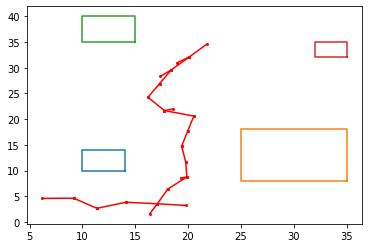

In [4]:
plt.figure()
for edge in graph.edges:
    parent_idx, child_idx = edge
    _, _, end_eff_p = graph_dictionary[parent_idx]
    _, _, end_eff_c = graph_dictionary[child_idx]
    plt.plot([end_eff_p.x(), end_eff_c.x()], [end_eff_p.y(), end_eff_c.y()], "ro-", markersize=2)
for obstacle in env.obstacles:
    plt.plot(*obstacle.exterior.xy)
plt.show()

In [5]:
end_effector_path_x = []
end_effector_path_y = []
for node in path:
    end_effector_path_x.append(node[2].x())
    end_effector_path_y.append(node[2].y())
fig = plt.figure()
fig.set_dpi(100)
ax = plt.axes(xlim=(-5, max_x), ylim=(-5, max_y))
plt.rc('animation', html='jshtml') # needed for animations!
#ax = plt.axes()
plt.close()
N = len(path)
# size=10.5
len_b = 2
d = np.sqrt(2*len_b*len_b/4)
omega = 2*math.pi/N
# arm = FourLinkMM()
# arm.x_b = 0
# arm.y_b = 0
# arm.theta_b = 0
q = np.radians(vector4(90,30,45,0))
sTt_initial = arm.fwd_kinematics(q)
print(sTt_initial)
print(q)
# ax.legend()

(-4.64778, 7.30755, 2.87979)

[1.57079633 0.52359878 0.78539816 0.        ]


In [6]:
def init():

  # For animation
    rect = mpatches.Rectangle([arm.x_b-d*np.cos(arm.theta_b+np.radians(45)),arm.y_b-d*np.sin(arm.theta_b+np.radians(45))], len_b, len_b, angle = arm.theta_b*180/np.pi)
    ax.plot(QGoal.x(), QGoal.y(), marker="o", markersize=8)
    #     ax.add_patch(rect)
#     ax.add_patch(link_1)
#     ax.add_patch(link_2)
#     ax.add_patch(link_3)
#     ax.add_patch(link_4)
#     ax.add_patch(mpatches.FancyArrow(arm.x_b,arm.y_b, 1.5*np.cos(arm.theta_b), 1.5*np.sin(arm.theta_b), color='r',head_width = 0.3))

    return rect, link_1, link_2, link_3, link_4,


def animate(i):

    global path
    global end_effector_path_x
    global end_effector_path_y
    global arm
    global q
    global prev_pose
    global curr_pose
    global env
    # Computes the forward kinematics to get the pose of the end-effector for the given angular position of the joints (q)
    base, q, end_effector = path[i]
    #     base, q = arm.ik2(poses[i])
    arm.update_manipulator_model(base, q)
    sTt = arm.fwd_kinematics(q)

    # Get the jacobian of the arm at the given pose
    # ------------------------- ANIMATION ----------------------------------------------------
    rect = mpatches.Rectangle([arm.x_b-d*np.cos(arm.theta_b+np.radians(45)),arm.y_b-d*np.sin(arm.theta_b+np.radians(45))],
                    len_b, len_b, angle = arm.theta_b*180/np.pi, color = 'b')
    #ax.clear()
    ax.clear()
    for obstacle in env.obstacles:
        ax.plot(*obstacle.exterior.xy)
    ax.plot(end_effector_path_x, end_effector_path_y, "ro-", markersize=2)
#     if prev_pose is None:
#         obj = ax.plot(curr_pose.x(), curr_pose.y(), marker="o", markersize=3)
#     #         ax.add_artist(obj)
#         prev_pose = curr_pose
#         curr_pose = poses[i + 1]
#     else:
#         obj = ax.plot([prev_pose.x(), curr_pose.x()], [prev_pose.y(), curr_pose.y()], "ro-", markersize=3)
#     #         ax.add_artist(obj)
#         prev_pose = curr_pose
#     if i + 1 < len(poses):
#         curr_pose = poses[i + 1]
    ax.add_patch(rect)
    
    #link 1
    sXl1 = Pose2(0, 0, arm.theta_b)
    l1Zl1 = Pose2(0, 0, q[0])
    l1Xl2 = Pose2(arm.L1, 0, 0)
    sTl2 = compose(sXl1, l1Zl1, l1Xl2)
    t1 = sTl2.translation()

    #link 2
    l2Zl2 = Pose2(0, 0, q[1])
    l2Xl3 = Pose2(arm.L2, 0, 0)
    sTl3 = compose(sTl2, l2Zl2, l2Xl3)
    t2 = sTl3.translation()

    #link 3
    l3Zl3 = Pose2(0, 0, q[2])
    l3X4 = Pose2(arm.L3, 0, 0)
    sTl4 = compose(sTl3, l3Zl3, l3X4)
    t3 = sTl4.translation()

    #link 4
    l4Zl4 = Pose2(0, 0, q[3])
    l4Xt = Pose2(arm.L4, 0, 0)
    sTt = compose(sTl4, l4Zl4, l4Xt)
    t4 = sTt.translation()
    
    #link 1
#     sXl1 = Pose2(0, 0, arm.theta_b)
#     l1Zl1 = Pose2(0, 0, q[0])
#     l1Xl2 = Pose2(arm.L1, 0, 0)
#     sTl2 = compose(sXl1, l1Zl1, l1Xl2)
#     t1 = sTl2.translation()
    ax.add_artist(mpatches.Rectangle([arm.x_b,arm.y_b], 3.5, 0.1, angle =np.rad2deg(arm.theta_b+q[0]), color='r'))
    
    #link2
#     l2Xl3 = Pose2(arm.L2, 0, 0)
#     sTl3 = compose(sTl2, l2Zl2, l2Xl3)
#     t2 = sTl3.translation()
    ax.add_artist(mpatches.Rectangle([t1.x()+arm.x_b,t1.y()+arm.y_b], 3.5, 0.1, angle =np.rad2deg(arm.theta_b+q[0]+q[1]), color='g'))

    #link3
#     l3Zl3 = Pose2(0, 0, q[2])
#     l3X4 = Pose2(arm.L3, 0, 0)
#     sTl4 = compose(sTl3, l3Zl3, l3X4)
#     t3 = sTl4.translation()
    ax.add_artist(mpatches.Rectangle([t2.x()+arm.x_b,t2.y()+arm.y_b], 2.5, 0.1, angle = np.rad2deg(arm.theta_b+q[0]+q[1]+q[2]), color='b'))

    #link4
#     l4Zl4 = Pose2(0, 0, q[3])
#     l4Xt = Pose2(arm.L4, 0, 0)
#     sTt = compose(sTl4, l4Zl4, l4Xt)
#     t4 = sTt.translation()
    ax.add_artist(mpatches.Rectangle([t3.x()+arm.x_b,t3.y()+arm.y_b], 0.5, 0.1, angle =np.rad2deg(arm.theta_b+q[0]+q[1]+q[2]+q[3]), color='k'))


    return rect, 

# Animation

In [7]:
animation.FuncAnimation(fig, animate, init_func=init,
                        frames=N, interval=500, blit=False)
# plt.show()